# Step 1: Loading Libraries


In [11]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

#Step 2: Loading the Datasets

In [12]:
census = gpd.read_file("/content/drive/MyDrive/CS896/PLACES__Census_Tract_Data_(GIS_Friendly_Format).csv")
health = pd.read_csv("/content/drive/MyDrive/CS896/PLACES__Local_Data_for_Better_Health,_Census_Tract_Data.csv")
#health = pd.read_csv("/content/drive/MyDrive/CS896/PLACES__Local_Data_for_Better_Health,_Census_Tract_Data.csv", engine='python', on_bad_lines='warn')
zcta = gpd.read_file("/content/drive/MyDrive/CS896/PLACES__ZCTA_Data_(GIS_Friendly_Format).csv")
parcels = gpd.read_file("/content/drive/MyDrive/CS896/PLACES__Local_Data_for_Better_Health,_Place_Data.csv")

#Week 3

###Selecting Important Columns

In [52]:
selected_cols = [
    "TractFIPS",
    "TotalPopulation",
    "OBESITY_CrudePrev",
    "DIABETES_CrudePrev",
    "BPHIGH_CrudePrev",
    "STROKE_CrudePrev",
    "LPA_CrudePrev",
    "CSMOKING_CrudePrev",
    "ACCESS2_CrudePrev"
]

tract_data = census[selected_cols].copy()


In [53]:
print(tract_data.head())
print(tract_data.shape)

     TractFIPS TotalPopulation  OBESITY_CrudePrev  DIABETES_CrudePrev  \
0  01001020100            1912               38.7                11.0   
1  01001020200            2170               45.0                13.7   
2  01001020300            3373               39.4                11.5   
3  01001020400            4386               34.8                10.3   
4  01001020500           10766               36.3                 8.9   

  BPHIGH_CrudePrev STROKE_CrudePrev LPA_CrudePrev CSMOKING_CrudePrev  \
0             37.7              3.0          29.6               18.0   
1             42.2              3.6          35.3               20.6   
2             38.5              3.3          31.5               18.7   
3             38.3              3.1          25.7               13.5   
4             33.7              2.4          24.7               14.3   

  ACCESS2_CrudePrev  
0              10.2  
1              13.7  
2              11.4  
3               7.9  
4               8.

##Cleaning & Converting to Numeric

In [36]:
# Converting numeric columns
numeric_cols = tract_data.columns.drop("TractFIPS")

tract_data[numeric_cols] = tract_data[numeric_cols].apply(
    pd.to_numeric, errors="coerce"
)

# Checking missing values
print(tract_data.isna().sum())


TractFIPS                0
TotalPopulation          0
OBESITY_CrudePrev     4165
DIABETES_CrudePrev    4165
BPHIGH_CrudePrev      4165
STROKE_CrudePrev      4165
LPA_CrudePrev         4165
CSMOKING_CrudePrev    4165
ACCESS2_CrudePrev     4165
dtype: int64


In [39]:
#deleting missing values
tract_data = tract_data.dropna()


In [40]:
tract_data.describe()

,TotalPopulation,OBESITY_CrudePrev,DIABETES_CrudePrev,BPHIGH_CrudePrev,STROKE_CrudePrev,LPA_CrudePrev,CSMOKING_CrudePrev,ACCESS2_CrudePrev
count,68172.000000,68172.000000,68172.000000,68172.000000,68172.000000,68172.000000,68172.000000,68172.000000
mean,4253.095948,34.343782,10.947423,32.099337,3.126735,25.220566,16.480840,11.393939
std,1915.707768,7.052591,3.743231,7.217030,1.065385,8.087518,5.949811,7.575976
min,56.000000,12.600000,0.700000,4.800000,0.300000,7.400000,3.000000,1.500000
25%,2908.000000,29.500000,8.400000,27.300000,2.400000,19.100000,12.100000,6.400000
50%,4010.000000,34.500000,10.300000,31.600000,3.000000,24.300000,15.900000,9.100000
75%,5318.000000,39.000000,12.800000,36.400000,3.600000,30.200000,20.100000,14.000000
max,37452.000000,62.100000,46.100000,73.300000,17.400000,63.900000,51.700000,65.100000


##Correlation Analysis

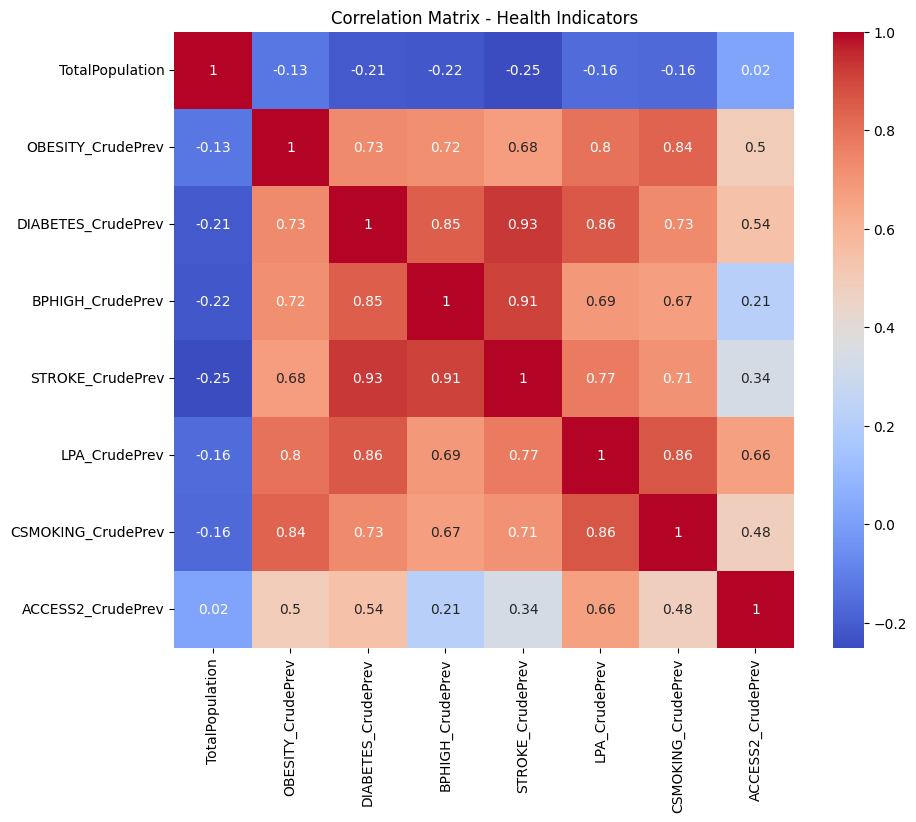

In [41]:
corr_matrix = tract_data[numeric_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix - Health Indicators")
plt.show()

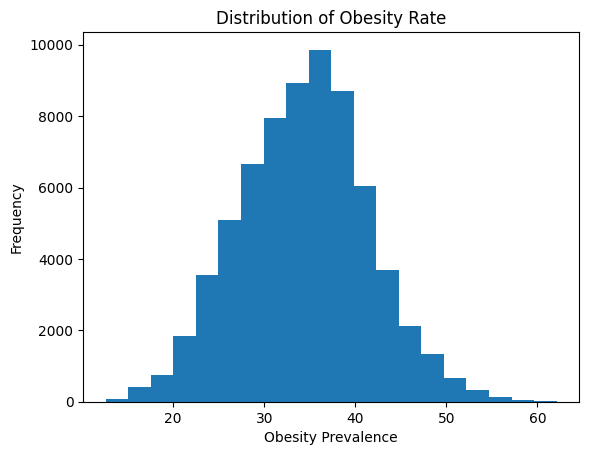

In [42]:
plt.hist(tract_data["OBESITY_CrudePrev"], bins=20)
plt.title("Distribution of Obesity Rate")
plt.xlabel("Obesity Prevalence")
plt.ylabel("Frequency")
plt.show()


##Normalizing Variables (Min-Max Scaling)

In [43]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_values = scaler.fit_transform(
    tract_data[numeric_cols]
)

scaled_df = pd.DataFrame(
    scaled_values,
    columns=numeric_cols
)

scaled_df["TractFIPS"] = tract_data["TractFIPS"].values


##Creating Vulnerability Score

In [44]:
scaled_df["VulnerabilityScore"] = (
    scaled_df["OBESITY_CrudePrev"] +
    scaled_df["DIABETES_CrudePrev"] +
    scaled_df["BPHIGH_CrudePrev"] +
    scaled_df["STROKE_CrudePrev"] +
    scaled_df["LPA_CrudePrev"] +
    scaled_df["CSMOKING_CrudePrev"] +
    scaled_df["ACCESS2_CrudePrev"]
) / 7

In [45]:
scaled_df = scaled_df.sort_values(
    by="VulnerabilityScore",
    ascending=False
)

scaled_df[["TractFIPS", "VulnerabilityScore"]].head(10)

,TractFIPS,VulnerabilityScore
42003,36081042600,0.779131
30681,26163553400,0.726387
754,01097000402,0.722848
46286,39035112100,0.700490
54959,45079010806,0.699672
42194,39035113101,0.695213
56528,47157011200,0.692622
32470,28047000100,0.689816
60203,48245006100,0.688611
55838,47065001600,0.687270


##Checking for Duplicate Values

In [46]:
# Checks full duplicate rows
print("Duplicate rows:", tract_data.duplicated().sum())


Duplicate rows: 0


In [47]:
print("Duplicate TractFIPS:", tract_data["TractFIPS"].duplicated().sum())


Duplicate TractFIPS: 0


##Checking Missing Values

In [48]:
missing = tract_data.isna().sum()
print(missing)


TractFIPS             0
TotalPopulation       0
OBESITY_CrudePrev     0
DIABETES_CrudePrev    0
BPHIGH_CrudePrev      0
STROKE_CrudePrev      0
LPA_CrudePrev         0
CSMOKING_CrudePrev    0
ACCESS2_CrudePrev     0
dtype: int64


In [49]:
missing_percent = (tract_data.isna().sum() / len(tract_data)) * 100
print(missing_percent)


TractFIPS             0.0
TotalPopulation       0.0
OBESITY_CrudePrev     0.0
DIABETES_CrudePrev    0.0
BPHIGH_CrudePrev      0.0
STROKE_CrudePrev      0.0
LPA_CrudePrev         0.0
CSMOKING_CrudePrev    0.0
ACCESS2_CrudePrev     0.0
dtype: float64
